In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

<h1>Starting Out</h1>

Starting out, we wanted to transform our data and train it on a very simply model. Once we got everything set up and ready, we will scale up and change some aspects of the model to fit our needs.

<h3>Transform Our Data</h3>

Since we have some categorical data, we need to transform it into numerical data. We will use the <code>LabelEncoder()</code> to do this. We will also use the <code>MinMaxScaler()</code> to scale our data. Once that is done, we will split our data into training and testing sets, saving them as parquet files so we do not have to do this every time we run the notebook (and we can just load the data in for subsequent notebooks).

In [80]:
# Load dataset
df = pd.read_parquet('pitch_dist_by_game.parquet')

# Convert categorical variables to numerical representations
label_encoder = LabelEncoder()
df['p_throws'] = label_encoder.fit_transform(df['p_throws'])
df['batter_stance'] = label_encoder.fit_transform(df['batter_stance'])
df['pitch_type'] = label_encoder.fit_transform(df['pitch_type'])
df['full_name'] = label_encoder.fit_transform(df['full_name'])

# Handle missing values (drop rows with missing values in this example)
df.dropna(inplace=True)

# Normalize numeric features (Min-Max scaling in this example)
numeric_columns = ['p_throws', 'batter_id', 'batter_stance', 'full_name', 'b_score', 'b_count', 's_count', 'current_outs', 'on_1b', 'on_2b', 'on_3b',
                   'inning', 'p_score', 'FF', 'CU', 'FC', 'SI', 'CH', 'FT', 'IN', 'SL', 'FS',
                   'KC', 'Unknown', 'PO', 'FO', 'EP', 'UN', 'KN', 'FA', 'SC', 'AB']

scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Select relevant features (including 'full_name' and 'batter_id')
relevant_columns = ['full_name', 'batter_id', 'b_score', 'b_count', 's_count', 'current_outs', 'on_1b',
                    'on_2b', 'on_3b', 'inning', 'p_score', 'p_throws', 'batter_stance',
                    'top', 'CH', 'CU', 'FC', 'FF', 'FS',
                    'FT', 'IN', 'KC', 'KN', 'PO',
                    'SC', 'SI', 'SL', 'UN', 'Unknown',
                    'EP', 'FA', 'pitch_type']

df = df[relevant_columns]

# Split df into training and testing data.
train, test = train_test_split(df, shuffle=True, random_state=4434)

# Turn the data into their respective parquet files.
train.to_parquet('training_data.parquet')
test.to_parquet('testing_data.parquet')

# Print the top 10 rows of the dataframe just to look at it.
df.head(10)

,full_name,batter_id,b_score,b_count,s_count,current_outs,on_1b,on_2b,on_3b,inning,...,KN,PO,SC,SI,SL,UN,Unknown,EP,FA,pitch_type
0,0.523179,0.815904,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,0.523179,0.815904,0.0,0.00,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
2,0.523179,0.815904,0.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
3,0.523179,0.815904,0.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
4,0.523179,0.815904,0.0,0.25,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
5,0.523179,0.815904,0.0,0.50,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
6,0.523179,0.720228,0.0,0.00,0.0,0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
7,0.523179,0.720228,0.0,0.25,0.0,0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
8,0.523179,0.523482,0.0,0.00,0.0,0.5,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
9,0.523179,0.523482,0.0,0.25,0.0,0.5,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


<h2>Creating Datasets and DataLoaders</h2>

We will create two different dataset classes: one for our training data, and one for our testing data. Once these are done,we will also create a two dataloaders that will be used to create our training and testing data. We will use the dataloaders to train our model.

In [86]:
# Build dataset and dataloader.
class PitchDatasetTrain(Dataset):
    def __init__(self):
        # Read in data
        df = pd.read_parquet('training_data.parquet')

        # Convert data to PyTorch tensors
        x_data = df.drop(columns=['pitch_type'])
        self.X = torch.tensor(x_data.to_numpy().astype(np.float32))
        self.y = torch.tensor(df['pitch_type'].values, dtype=torch.long)
        # self.y = self.y.reshape(-1, 1)
        self.n_samples = df.shape[0]
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
    
class PitchDatasetTest(Dataset):
    def __init__(self):
        # Read in data
        df = pd.read_parquet('test_data.parquet')

        # Convert data to PyTorch tensors
        x_data = df.drop(columns=['pitch_type'])
        self.X = torch.tensor(x_data.to_numpy().astype(np.float32))
        self.y = torch.tensor(df['pitch_type'].values, dtype=torch.long)
        self.n_samples = df.shape[0]
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

# Create the dataset and dataloader.
train_data = PitchDatasetTrain()
test_data = PitchDatasetTrain()
batch_size, num_workers = 32, 2
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

<h3>Helper Functions</h3>

These are the functions we will use in our model and/or training loop. So far we only have a function to calculate the accuracy of our model.

In [87]:
# Build helper functions (such as checking accuracy)
def calculate_accuracy(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [93]:
# Build the DNN

# First, define the hyperparameters
input_size = 31  # Input size (e.g., number of features)
hidden_size = 64  # Size of the hidden layer(s)
output_size = 19  # Output size (e.g., number of classes)
learning_rate = 0.001

# Define the neural network architecture
class MyDNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyDNN, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_size, hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, output_size))

    def forward(self, x):
        return self.net(x)

# Create an instance of the model
model = MyDNN(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define variables for training loop.
num_epochs = 10
total_samples = len(train_data)
n_iterations = np.ceil(total_samples/batch_size)

# Define variables for storing our loss and accuracy.
loss_vals, loss_occ = [], []
acc_vals, acc_occ = [], []

# Run training loop.
for epoch in range(num_epochs):
    # Create our tqdm progress bar.
    tqdm_data_loader = tqdm(train_dataloader, total=n_iterations, desc=f'Epoch [{epoch + 1}/{num_epochs}]', dynamic_ncols=True)


    # Check the model's accuracy (do this for every epoch).
    acc_vals.append(calculate_accuracy(model, test_dataloader))

    # Create a list to hold the current epochs loss values (to average for the tqdm bar).
    curr_loss = []

    # Train the model.
    for i, (inputs, labels) in enumerate(tqdm_data_loader):
        optimizer.zero_grad()  # Clear gradients from previous iteration
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters
        loss_vals.append(loss.item())
        curr_loss.append(loss.item())

        # Update our tqdm loop so we can see what is happening.
        tqdm_data_loader.set_postfix(loss=np.mean(curr_loss), acc=acc_vals[-1])
    

# After training, you can save the model
torch.save({'model': model.state_dict(),
            'optim': optimizer.state_dict()}, 'pitch_dnn_1.pth')


Epoch [1/10]:   0%|          | 0/82368.0 [00:10<?, ?it/s]
Epoch [1/10]: 100%|██████████| 82368/82368.0 [07:28<00:00, 183.81it/s, acc=0.0631, loss=1.08]
Epoch [2/10]: 100%|██████████| 82368/82368.0 [15:56<00:00, 86.11it/s, acc=0.549, loss=0.986]   
Epoch [3/10]: 100%|██████████| 82368/82368.0 [06:59<00:00, 196.35it/s, acc=0.552, loss=0.982]
Epoch [4/10]: 100%|██████████| 82368/82368.0 [07:04<00:00, 193.86it/s, acc=0.553, loss=0.98] 
Epoch [5/10]: 100%|██████████| 82368/82368.0 [06:48<00:00, 201.46it/s, acc=0.551, loss=0.979]
Epoch [6/10]: 100%|██████████| 82368/82368.0 [07:06<00:00, 193.23it/s, acc=0.554, loss=0.978]
Epoch [7/10]: 100%|██████████| 82368/82368.0 [13:07<00:00, 104.61it/s, acc=0.554, loss=0.978]  
Epoch [8/10]: 100%|██████████| 82368/82368.0 [07:13<00:00, 190.16it/s, acc=0.553, loss=0.978]
Epoch [9/10]: 100%|██████████| 82368/82368.0 [2:07:02<00:00, 10.81it/s, acc=0.554, loss=0.977]    
Epoch [10/10]: 100%|██████████| 82368/82368.0 [8:33:37<00:00,  2.67it/s, acc=0.554, los

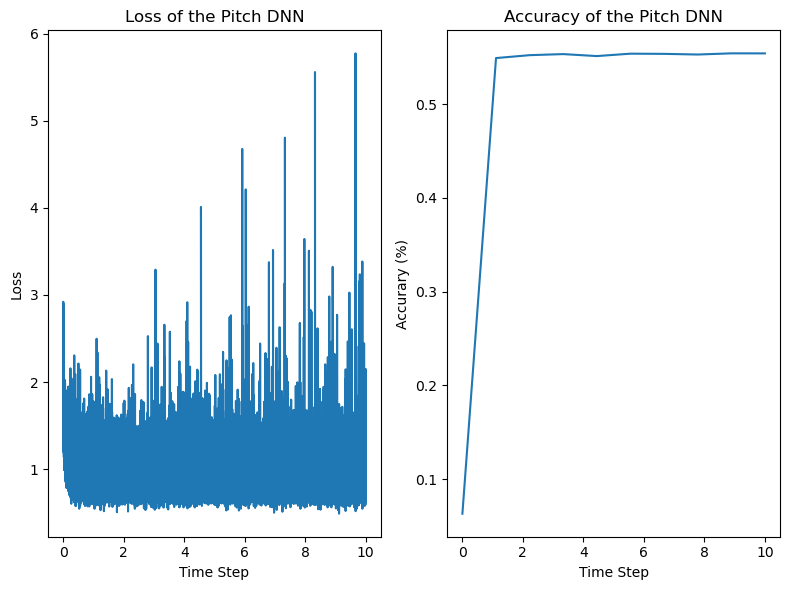

In [97]:
# Plot the outputs of our model (the training and the accurary)
fig, ax = plt.subplots(1, 2, figsize=(8,6), dpi=100)

# Plot the loss
ax[0].plot(np.linspace(0, num_epochs, len(loss_vals)), loss_vals)
ax[0].set_xlabel('Time Step')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss of the Pitch DNN')

# Plot the accuracy
ax[1].plot(np.linspace(0, num_epochs, len(acc_vals)), acc_vals)
ax[1].set_xlabel('Time Step')
ax[1].set_ylabel('Accurary (%)')
ax[1].set_title('Accuracy of the Pitch DNN')

plt.tight_layout()
plt.show()
